<a href="https://colab.research.google.com/github/bearylogical/bayesian_mm/blob/main/notebooks/emcee_strain_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Material estimation using bayesian parameter estimation

## Import Libraries

In [1]:
!pip install emcee corner

     |████████████████████████████████| 45 kB 1.8 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal

np.random.seed(123)


# Define our constants

In [3]:
length_scale = 1
# constants
true_G = 9867.9056 / length_scale
true_K = 60776.0301 / length_scale

A = np.array([[1, -1], [2,  1]])
A_inv = np.linalg.inv(A)

p_0 = 11220 / length_scale
true_p_wall = 19946.5733

r_0, l_0 = 117.9 / length_scale , 313.0 / length_scale
alpha = 0.064
rr_1, ll_1 = 95.014/ length_scale , 390.641 / length_scale


## Generate our data

We take one observation of $r_1, l_1$ and purturb the result with random noise to obtain a set of $N$ observations

In [5]:
N = 10 # number of "observations"
y_err = 0.5 + 0.5 * np.random.rand(2, N) 
y_true = np.array([[rr_1, ll_1]]).T
y = y_true + y_err
cov = np.cov(y_err)

In [18]:
cov 

array([[ 0.01172084, -0.00732869],
       [-0.00732869,  0.0159331 ]])

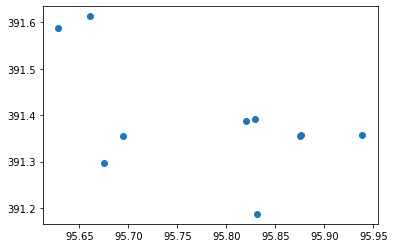

In [21]:
plt.scatter(y[0,:], y[1,:])

Posterior Probability 
$$ P(G, K \mid r_0, l_0, α, r_1, l_1, \Sigma, p) \propto P(r_1, l_1, G, K, p_{\mathrm{wall}})P(r_1, l_1 | G, K, r_0, l_0, \alpha, p, p_{\mathrm{wall}})$$

In [6]:
# def p_wall(r, l, alpha, p):
#   return (p * (r + 0.5 * l * np.tan(alpha)) ** 2 ) / ( 2 * np.sin(alpha) * r * l * np.sqrt(1+ (np.tan(alpha))**2)) 

def model(G, K, p_wall, r_0=r_0, l_0=l_0, p_0=p_0):
  delta_P = p_wall - p_0
  p_avg =  1/3 * (2 * p_wall + p_0)
  b1 = delta_P / (2 * G)
  b2 = p_avg / (2 * K)
  b = np.hstack([b1, b2]).T
  eps = A_inv.dot(b) #[er, ez]
  
  if eps.ndim == 1:
    er,ez = eps[0], eps[1]
    r_1 = r_0 - er * r_0
    l_1 = l_0 - ez * l_0
    return r_1, l_1 
  else:
    er, ez = eps[0,:], eps[1,:]
    r_1 = r_0.T - er * r_0.T
    l_1 = l_0.T - ez * l_0.T
    return np.vstack([r_1, l_1]).T

## Test our model function

In [7]:
model(true_G, true_K, true_p_wall, r_0, l_0, p_0)

(95.01413513065441, 390.64183056808895)

# Define our likelihood

Use the multivariate log likelihood
$$\ln L(x) = - \frac{1}{2}\Big[\ln(|Σ|) + (x - \mu)^T \Sigma^{-1} (x-\mu) + k \ln(2\pi)\Big]$$ 

Since it is a bivariate normal due to the joint observation of $r_1, l_1$ --> $k=2$.

In [8]:
def log_likelihood(theta, x, y, cov):
  G, K, p_wall = theta 
  r_0, l_0, p_0 = np.hsplit(x, 3)  
  y_pred = model(G, K, p_wall, r_0, l_0, p_0)
  res = y - y_pred
  def calc_loglikelihood(res):
    return -0.5 * (np.log(np.linalg.det(cov)) + res.T.dot(np.linalg.inv(cov)).dot(res) + 2 * np.log(2 * np.pi))

  loglikelihood = np.apply_along_axis(calc_loglikelihood, 1, res)
  return loglikelihood.sum()

# Obtain the MLE of the log likelihood

In [9]:
# solve via MLE
from scipy.optimize import minimize

x = np.array((r_0, l_0, p_0)) + 0.1 + np.random.randn(3, N).T
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_G, true_K, true_p_wall]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y.T, cov))
G_ml, K_ml, p_wall_ml = soln.x

print("Maximum likelihood estimates:")
print(f"G = {G_ml:.3f}")
print(f"K = {K_ml:.3f}")
print(f"p_wall = {p_wall_ml:.3f}")

Maximum likelihood estimates:
G = 8300.481
K = 62120.255
p_wall = 18463.884


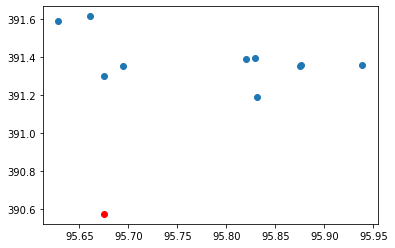

In [27]:
pred = model(G_ml, K_ml, p_wall_ml, r_0, l_0, p_0)
plt.scatter(y[0,:], y[1,:])
plt.scatter(x=pred[0], y=pred[1], c='red')

# Define our Priors

Try a uniform distribution based on known values of G, K and p_wall.

Say, $8000 \lt G \lt 11000$, $60000 \lt K \lt 70000$, $1100 \lt p_{\mathrm{wall}} \lt 21000$.

We use our understanding of our previous experiments to shape our prior. In particular we assume that there is equal (uniform) probability that values within the range above are equally likely i.e. P(value) = 1.

In [10]:
def log_prior(theta):
  G, K, p_wall = theta
  if 8e3 < G < 1.1e4 and 6e4 < K < 7e4 and 1.1e4 < p_wall < 2.1e4:
    return 0.0 # ln(1) = 0
  return -np.inf


# Define our posterior function

Because we are taking the log of the posterior, we can formulate the posterior as a sum of the (log) prior and the (log) likelihood.

In [11]:
def log_probability(theta, x, y, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, cov)

Use `emcee` to sample from our posterior

`emcee` needs somewhere to start. We use the MLE result as a starting point for the random walk.

In [12]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y.T, cov)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [02:20<00:00, 35.51it/s]


## Model Diagnostics

In this section we visualise the results of the sampling procedure to get some view of the stability of the chain samples.

In [13]:
import matplotlib.pyplot as plt

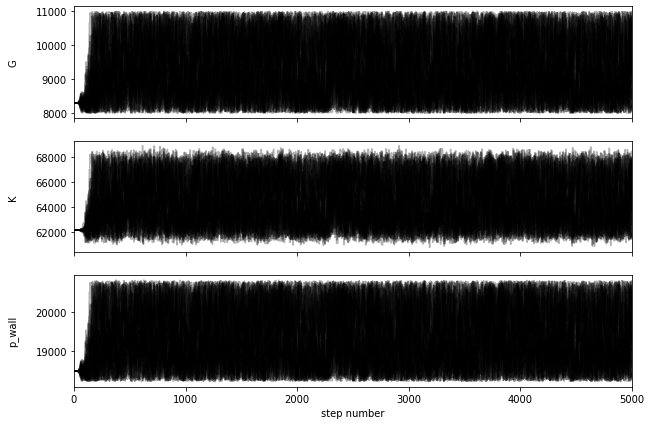

In [14]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["G", "K", "p_wall"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[50.83511988 50.30297974 50.83485981]


In [16]:
flat_samples = sampler.get_chain(discard=1000, thin=25, flat=True)
print(flat_samples.shape)

(5120, 3)


# Results

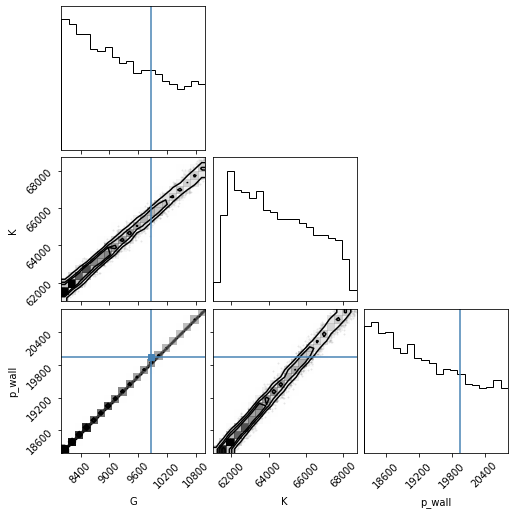

In [17]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_G, true_K, true_p_wall]
);